# Azure MLで学習済みモデルの作成からデプロイまで

このチュートリアルでは、`Azure Machine Learning（Azure ML）Python SDK`を使用して、  
モデルのトレーニング、ハイパーパラメーターの調整、およびデプロイを行います。  
※ディープラーニングのフレームワークには`PyTorch`を使用します。  


問題設定は[Transfer Learningチュートリアル](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)から、  Transfer Learning（転移学習）を使用してアリとハチの画像分類になります。  

*転移学習とは？*  
転移学習とは学習済みモデルを使用して（ネットワークの構造と重みの再利用）、学習を行うことをさします。  
類似のものとしてファインチューニングがありますが、学習済みモデルのネットワークの学習を行うのがファインチューニングになります。  
転移学習では学習済みモデルのネットワーク自体の学習は行いません。（出力前の全結合層のみを学習させるのが一般的）  

## 環境構築

環境は「[Azure Machine Learning Services](https://docs.microsoft.com/ja-jp/azure/machine-learning/service/) ワークスペース」にある`Azure Notebooks`を使用します。  
Pythonの実行環境や、Azure ML Servicesを使用に必要な[Azure ML Python SDK](https://docs.microsoft.com/ja-jp/python/api/overview/azure/ml/intro?view=azure-ml-py)は既にインストールされています。　  

この画面の右上の Kernel が `Python 3.6` になっていることを確認します。異なる場合は、[Kernel] メニューから、変更してください。

### バージョンの確認

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.15


AzrueML上では既にAzureML Python SDKが準備されているため、インストールする必要はありません。  

### ワークスペースの初期化

0.configuration.ipynb を実行して、`config.json` ファイルを作成済みの場合は、このセルはスキップして次に進んでください。

[ワークスペース](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace)の初期化を行います。  
`Workspace.from_config()`は`config.json`ファイルを参照してワークスペースを初期化します。  

#### configファイルの編集

`config.json`ファイルは基本的に自動でこのように設定を反映されます。  
自身で設定する際には下記のように編集します。  

```json

{
    "subscription_id": "サブスクリプションID",
    "resource_group": "リソースグループ名",
    "workspace_name": "ワークスペース名"
}

```

上記の情報はAzure Portalの画面から確認することができます。  
では、実行して、ワークスペースの初期化を行います。  

初期化を行う時に、サインインを要求されるので、表示されるコードをコピーして、URLをクリックします。  
遷移先の画面でコピーしたコードを入力することによって、サインインが完了します。  

In [2]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Found the config file in: /home/nbuser/library/aml_config/config.json
Workspace name: dahatakemlws
Azure region: westus2
Resource group: dahatakeml


## コンピューティング ターゲットの設定

[コンピューティングターゲット](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target)を作成する必要があります。このチュートリアルではAzure ML managed compute ([AmlCompute](https://docs.microsoft.com/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute))を使用します。  
（コンピューティングターゲットは計算を実行する場所を決定するようなイメージです。）

※AmlComputeの作成には約5分かかります。  
その名前のAmlComputeが既にワークスペースにある場合、このコードは作成プロセスをスキップします。

他のAzureサービスと同様に、Azure Machine Learningサービスに関連する特定のリソース（AmlComputeなど）には制限があります。  
デフォルトの制限と、より多くのクォータを要求する方法についての[この記事](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas)を読んでください。

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_NC6s_v3", ## Standard_NC6
                                                       min_nodes=1,
                                                       max_nodes=4) ## vm_priority='lowpriority' | `dedicated'

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# Use the 'status' property to get a detailed status for the current cluster. 
print(compute_target.status.serialize())

Found existing compute target.
{'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-02-14T17:44:35.515000+00:00', 'creationTime': '2019-02-14T17:43:13.762419+00:00', 'currentNodeCount': 1, 'errors': None, 'modifiedTime': '2019-02-14T17:43:34.704473+00:00', 'nodeStateCounts': {'idleNodeCount': 1, 'leavingNodeCount': 0, 'preemptedNodeCount': 0, 'preparingNodeCount': 0, 'runningNodeCount': 0, 'unusableNodeCount': 0}, 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'targetNodeCount': 1, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


上記のコードはGPUクラスターを作成します。  
コードの中身を確認します。  
`AmlCompute.provisioning_configuration()`でコンピューティング ターゲットの設定を行うことができます。  
詳細は[こちらの公式ドキュメント](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.compute.amlcompute(class)?view=azure-ml-py)を確認してください。  


### 仮想マシンのサイズの変更

代わりにCPUクラスタを作成したい場合は、 `STANDARD_D2_V2`のように` vm_size`パラメータに異なるVMサイズを指定してください。  

CPUのVMサイズは[こちらの公式ドキュメント](https://docs.microsoft.com/ja-jp/azure/virtual-machines/linux/sizes-general)を確認してください。  
GPUのVMサイズは[こちらの公式ドキュメント](https://docs.microsoft.com/ja-jp/azure/virtual-machines/linux/sizes-gpu)を確認してください。  

今回はNVIDIAのTesla K80が1枚の仮想マシン`STANDARD_NC6`を使用します。  
計算リソースを増やすためにはNCの他のシリーズを使用するもしくはGPUの枚数を増やすことによって行うことが可能です。  


### 仮想マシンの割り当ての設定

Azureの仮想マシンのプライオリティ（優先度）を選択することができます。  
選択肢は`dedicated`または`lowpriority`の２つから選択することができます。  
（デフォルトでは`dedicated`が選択されています。）  

dedicatedは問題なく仮想マシンが割り当てられますが、lowpriorityは価格が安い代わりに割り込みが入る可能性などいくつかデメリットがあります。  
しかし、価格が約8割ほど安くなるのは大きなメリットです。  


### クラスターのノード数の設定

`max_nodes`でコンピューティングでジョブを実行中に自動スケールアップする最大ノード数を指定することが可能です。  
ノード数はVMの数を表すため最大数が増えると計算リソースが増えますが、同時に発生する料金も増えます。  

## GPUクラスタを使用しての学習の実行

リモートコンピューティングクラスタを使用して学習する準備が整いました。  
Pytorchでの学習のスクリプトと学習用のデータを準備します。  

今回は事前に準備されたものを使用します。　　

### プロジェクトディレクトリの作成

学習実行に必要なコードを格納するディレクトリを作成します。  
このディレクトリには学習を実行するコードと、それに依存関係のファイルなどを格納するする必要があります。  

In [5]:
import os

project_folder = './pytorch-hymenoptera'
os.makedirs(project_folder, exist_ok=True)

今回は`pytorch-hymenoptera`という名前のプロジェクトフォルダを作成しました。  

### データセットの準備

今回は[こちら](https://download.pytorch.org/tutorial/hymenoptera_data.zip)のデータセットを使用します。  
（ダウンロードの必要はありません）


こちらにはアリとミツバチの画像それぞれ約120個ずつの訓練データ、75個の検証データが含まれています。  
学習用のスクリプトである`pytorch_train.py`内にデータセットをダウンロードして取得するコードがあるため、  
こちらのデータは今回はダウンロードして準備する必要はありません。  


### 学習用スクリプトの準備

学習用のスクリプトは用意されている`pytorch_train.py`を使用します。  


### スクリプトの確認

今回使用するスクリプトはこちらになります。  
`pytorch_train.py`  
こちらのスクリプトの詳細の説明は行いませんが、実行内容としては下記の4ステップになります。    

1. データのダウンロード
2. 必要な前処理の適応
3. 学習の実行
4. 結果の取得

In [6]:
%%writefile pytorch_train.py  

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import time
import os
import copy
import argparse

from azureml.core.run import Run
# get the Azure ML run object
run = Run.get_context()


def load_data(data_dir):
    """Load the train/val data."""

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                  shuffle=True, num_workers=4)
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names


def train_model(model, criterion, optimizer, scheduler, num_epochs, data_dir):
    """Train the model."""

    # load training/validation data
    dataloaders, dataset_sizes, class_names = load_data(data_dir)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # log the best val accuracy to AML run
            run.log('best_val_acc', np.float(best_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def fine_tune_model(num_epochs, data_dir, learning_rate, momentum):
    """Load a pretrained model and reset the final fully connected layer."""

    # log the hyperparameter metrics to the AML run
    run.log('lr', np.float(learning_rate))
    run.log('momentum', np.float(momentum))

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)  # only 2 classes to predict

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(),
                             lr=learning_rate, momentum=momentum)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer_ft, step_size=7, gamma=0.1)

    model = train_model(model_ft, criterion, optimizer_ft,
                        exp_lr_scheduler, num_epochs, data_dir)

    return model


def download_data():
    """Download and extract the training data."""
    import urllib
    from zipfile import ZipFile
    # download data
    data_file = './hymenoptera_data.zip'
    download_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(download_url, filename=data_file)

    # extract files
    with ZipFile(data_file, 'r') as zip:
        print('extracting files...')
        zip.extractall()
        print('finished extracting')
        data_dir = zip.namelist()[0]

    # delete zip file
    os.remove(data_file)
    return data_dir


def main():
    print("Torch version:", torch.__version__)

    # get command-line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_epochs', type=int, default=25,
                        help='number of epochs to train')
    parser.add_argument('--output_dir', type=str, help='output directory')
    parser.add_argument('--learning_rate', type=float,
                        default=0.001, help='learning rate')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
    args = parser.parse_args()

    data_dir = download_data()
    print("data directory is: " + data_dir)
    model = fine_tune_model(args.num_epochs, data_dir,
                            args.learning_rate, args.momentum)
    os.makedirs(args.output_dir, exist_ok=True)
    torch.save(model, os.path.join(args.output_dir, 'model.pt'))


if __name__ == "__main__":
    main()

Overwriting pytorch_train.py


### Azure MLの学習結果をログに保存

上記のコードにはAzure MLの環境で学習を実行し、結果を追跡するにはいくつかのAzure MLコードが追記されています。  
詳細は[こちらの公式のドキュメント](https://docs.microsoft.com/ja-jp/azure/machine-learning/service/how-to-track-experiments)を確認してください。  
今回記述されている内容をそれぞれ確認しましょう。  

学習経過には`Azure ML Run`オブジェクトを使用することによってアクセスすることができます。    
上記のコード内で設定を行なっている部分を確認しましょう。  

```Python
from azureml.core.run import Run
run = Run.get_context()
```

さらに`learning rate`、`momentum`のパラメータ、検証データに対する最高のAccuracy（正解率）のログも取得します。  

```Python
run.log('lr', np.float(learning_rate))
run.log('momentum', np.float(momentum))

run.log('best_val_acc', np.float(best_acc))
```

ハイパーパラメータの調整を行う際にこちらのログは重要な役割を果たします。  
こちらのスクリプトを先ほど作成した、作業ディレクトリに保存しておきます。  

In [7]:
import shutil

shutil.copy('pytorch_train.py', project_folder)

'./pytorch-hymenoptera/pytorch_train.py'

### Experimentの作成
ワークスペースですべての実行結果を追跡するために[Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) を作成します。  

In [8]:
from azureml.core import Experiment

experiment_name = 'pytorch-hymenoptera'
experiment = Experiment(ws, name=experiment_name)

### PyTorch estimatorの作成

Azure ML SDKのPyTorch estimatorを使用すると、単一ノードと分散の両方の実行について、PyTorchトレーニングジョブを簡単に送信できます。   
PyTorch estimatorの詳細については、[こちら](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-pytorch)を参照してください。次のコードは単一ノードのPyTorchジョブを定義します。

In [9]:
from azureml.train.dnn import PyTorch

script_params = {
    '--num_epochs': 30,
    '--output_dir': './outputs'
}

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target,
                    entry_script='pytorch_train.py',
                    use_gpu=True)

`scripti_params`に訓練に必要な引数を渡す必要があります。　　


#### script_params

`script_params`は` entry_script`で指定しているスクリプトに必要な引数を渡す辞書型のオブジェクトです。  
今回の設定は下記になります。  
- `--num_epochs`:`30`→エポック数を30に設定
- `'--output_dir': './outputs'`→学習の実行履歴を保存するディレクトリの指定

この出力ディレクトリである `./ output`はAzure ML上で特別に扱われます。  
このディレクトリ内の情報は全て実行履歴の一部としてワークスペースにアップロードされ、リモート実行が終了してもアクセス可能です。

#### データストアからデータの読み込み

訓練時にデータを読み込む必要がある場合はデータストアと呼ばれる場所にデータをUploadし、そこからデータを読み込む必要があります。  
その方法については[こちらの公式ドキュメント](https://docs.microsoft.com/ja-jp/azure/machine-learning/service/how-to-access-data)を確認してください。  
（データストアはワークスペースのリソースを作成した段階で使用可能になります。）  


#### GPUの使用

Azure VMのGPUをトレーニングに活用するには、`use_gpu = True`に設定します。
CPUしか利用できない場合は、このパラメーターを削除するか、`user_gpu=False` に設定しなおします。

各種パラメーター:
[PyTorch class](https://docs.microsoft.com/ja-jp/python/api/azureml-train-core/azureml.train.dnn.pytorch?view=azure-ml-py)

### ジョブの実行

Estimatorオブジェクトを送信してExperimentを実行します。  
この実行は非同期です。

環境にもよりますが、20分程度かかります。

In [10]:
run = experiment.submit(estimator)
print(run)

Run(Experiment: pytorch-hymenoptera,
Id: pytorch-hymenoptera_1550166436_c561f0f8,
Type: azureml.scriptrun,
Status: Starting)


In [11]:
# to get more details of your run
print(run.get_details())

{'runId': 'pytorch-hymenoptera_1550166436_c561f0f8', 'target': 'gpucluster', 'status': 'Starting', 'properties': {'azureml.runsource': 'experiment', 'ContentSnapshotId': '0af176fa-5604-4fa5-a369-d5477a13e8f7'}, 'runDefinition': {'Script': 'pytorch_train.py', 'Arguments': ['--num_epochs', '30', '--output_dir', './outputs'], 'SourceDirectoryDataStore': None, 'Framework': 0, 'Communicator': 0, 'Target': 'gpucluster', 'DataReferences': {}, 'JobName': None, 'AutoPrepareEnvironment': True, 'MaxRunDurationSeconds': None, 'NodeCount': 1, 'Environment': {'Python': {'InterpreterPath': 'python', 'UserManagedDependencies': False, 'CondaDependencies': {'name': 'project_environment', 'dependencies': ['python=3.6.2', {'pip': ['azureml-defaults', 'torch==1.0.0', 'torchvision==0.2.1']}]}}, 'EnvironmentVariables': {'EXAMPLE_ENV_VAR': 'EXAMPLE_VALUE', 'NCCL_SOCKET_IFNAME': '^docker0'}, 'Docker': {'BaseImage': 'mcr.microsoft.com/azureml/base-gpu:0.2.1', 'Enabled': True, 'SharedVolumes': True, 'Preparation

### 実行経過の確認

Jupyter Notebookのウィジェットを使用して実行の進行状況を監視できます。  
実行依頼と同様に、ウィジェットは非同期で、ジョブが完了するまで10〜15秒ごとにライブアップデートを行います。

また、このウィジェットの `Status` が `Queued` になると。実際にGPUマシンが自動的に作成されます。

ウィジェットの一番下にある `Click here to see the run in Azure portal` から、`コンピューティング` の状態も併せて確認してください。[最新の情報を更新] を押してリフレッシュすることをお勧めします。

In [12]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

また、スクリプトがトレーニングを完了するまでブロックしてから、学習結果を確認することも可能です。

In [13]:
run.wait_for_completion(show_output=True)

RunId: pytorch-hymenoptera_1550166436_c561f0f8

Streaming azureml-logs/20_image_build_log.txt

2019/02/14 17:47:28 Using acb_vol_ef0e7b8b-9ef9-47cd-a33f-044f5ed9f2f4 as the home volume
2019/02/14 17:47:28 Creating Docker network: acb_default_network, driver: 'bridge'
2019/02/14 17:47:28 Successfully set up Docker network: acb_default_network
2019/02/14 17:47:28 Setting up Docker configuration...
2019/02/14 17:47:29 Successfully set up Docker configuration
2019/02/14 17:47:29 Logging in to registry: dahatakemlws9411991381.azurecr.io
2019/02/14 17:47:30 Successfully logged into dahatakemlws9411991381.azurecr.io
2019/02/14 17:47:30 Executing step ID: acb_step_0. Working directory: '', Network: 'acb_default_network'
2019/02/14 17:47:30 Obtaining source code and scanning for dependencies...
2019/02/14 17:47:31 Successfully obtained source code and scanned for dependencies
2019/02/14 17:47:31 Launching container with name: acb_step_0
Sending build context to Docker daemon  40.96kB

Step 1/13

  Stored in directory: /root/.cache/pip/wheels/4e/5b/1b/be8c8a830a0243af85b2946a0aece2c6743d7f7f946977ed67
  Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
  Stored in directory: /root/.cache/pip/wheels/45/cb/7e/ce6e6062c69446e39e328170524ca8213498bc66a74c6a210b
  Stored in directory: /root/.cache/pip/wheels/f2/9a/90/de94f8556265ddc9d9c8b271b0f63e57b26fb1d67a45564511
Successfully built SecretStorage pyyaml pathspec pycparser
#
# To activate this environment, use:
# > source activate /azureml-envs/azureml_b597eaa6db1a149b61fa829fc32fb56d
#
# To deactivate an active environment, use:
# > source deactivate
#


Removing intermediate container b58b652f7ac6
 ---> 78562966569e
Step 9/13 : ENV PATH /azureml-envs/azureml_b597eaa6db1a149b61fa829fc32fb56d/bin:$PATH
 ---> Running in 7e86a9654c4a
Removing intermediate container 7e86a9654c4a
 ---> e58c8373faff
Step 10/13 : ENV LD_LIBRARY_PATH /azureml-envs/azureml_b597eaa6db1a149b61fa829fc32f

2019/02/14 17:50:25 Executing step ID: acb_step_1. Working directory: '', Network: 'acb_default_network'
2019/02/14 17:50:25 Pushing image: dahatakemlws9411991381.azurecr.io/azureml/azureml_5689f2b77783cb2ee9e24cf0fbc4498f:latest, attempt 1
The push refers to repository [dahatakemlws9411991381.azurecr.io/azureml/azureml_5689f2b77783cb2ee9e24cf0fbc4498f]
77aed2b7e1c5: Preparing
edf65a528998: Preparing
e7e38713b0d2: Preparing
ae2deca824f0: Preparing
90f6aa47930d: Preparing
c5088e4dcdf9: Preparing
1af194b284e7: Preparing
a47a9623d406: Preparing
51713b8e3669: Preparing
bf847be1c797: Preparing
553141bf0a37: Preparing
5fb2a9818ab4: Preparing
68dda0c9a8cd: Preparing
f67191ae09b8: Preparing
b2fd8b4c3da7: Preparing
0de2edf7bff4: Preparing
c5088e4dcdf9: Waiting
1af194b284e7: Waiting
a47a9623d406: Waiting
f67191ae09b8: Waiting
51713b8e3669: Waiting
bf847be1c797: Waiting
b2fd8b4c3da7: Waiting
553141bf0a37: Waiting
0de2edf7bff4: Waiting
5fb2a9818ab4: Waiting
68dda0c9a8cd: Waiting
77aed2b7e1c5: Push

18.9%
18.9%
18.9%
18.9%
18.9%
18.9%
19.0%
19.0%
19.0%
19.0%
19.0%
19.1%
19.1%
19.1%
19.1%
19.1%
19.1%
19.2%
19.2%
19.2%
19.2%
19.2%
19.2%
19.3%
19.3%
19.3%
19.3%
19.3%
19.3%
19.4%
19.4%
19.4%
19.4%
19.4%
19.5%
19.5%
19.5%
19.5%
19.5%
19.5%
19.6%
19.6%
19.6%
19.6%
19.6%
19.6%
19.7%
19.7%
19.7%
19.7%
19.7%
19.8%
19.8%
19.8%
19.8%
19.8%
19.8%
19.9%
19.9%
19.9%
19.9%
19.9%
19.9%
20.0%
20.0%
20.0%
20.0%
20.0%
20.0%
20.1%
20.1%
20.1%
20.1%
20.1%
20.2%
20.2%
20.2%
20.2%
20.2%
20.2%
20.3%
20.3%
20.3%
20.3%
20.3%
20.3%
20.4%
20.4%
20.4%
20.4%
20.4%
20.5%
20.5%
20.5%
20.5%
20.5%
20.5%
20.6%
20.6%
20.6%
20.6%
20.6%
20.6%
20.7%
20.7%
20.7%
20.7%
20.7%
20.7%
20.8%
20.8%
20.8%
20.8%
20.8%
20.9%
20.9%
20.9%
20.9%
20.9%
20.9%
21.0%
21.0%
21.0%
21.0%
21.0%
21.0%
21.1%
21.1%
21.1%
21.1%
21.1%
21.2%
21.2%
21.2%
21.2%
21.2%
21.2%
21.3%
21.3%
21.3%
21.3%
21.3%
21.3%
21.4%
21.4%
21.4%
21.4%
21.4%
21.4%
21.5%
21.5%
21.5%
21.5%
21.5%
21.6%
21.6%
21.6%
21.6%
21.6%
21.6%
21.7%
21.7%
21.7%
21.7%
21.7%
21.7%
21.8

45.2%
45.2%
45.3%
45.3%
45.3%
45.3%
45.3%
45.3%
45.4%
45.4%
45.4%
45.4%
45.4%
45.4%
45.5%
45.5%
45.5%
45.5%
45.5%
45.6%
45.6%
45.6%
45.6%
45.6%
45.6%
45.7%
45.7%
45.7%
45.7%
45.7%
45.7%
45.8%
45.8%
45.8%
45.8%
45.8%
45.9%
45.9%
45.9%
45.9%
45.9%
45.9%
46.0%
46.0%
46.0%
46.0%
46.0%
46.0%
46.1%
46.1%
46.1%
46.1%
46.1%
46.1%
46.2%
46.2%
46.2%
46.2%
46.2%
46.3%
46.3%
46.3%
46.3%
46.3%
46.3%
46.4%
46.4%
46.4%
46.4%
46.4%
46.4%
46.5%
46.5%
46.5%
46.5%
46.5%
46.6%
46.6%
46.6%
46.6%
46.6%
46.6%
46.7%
46.7%
46.7%
46.7%
46.7%
46.7%
46.8%
46.8%
46.8%
46.8%
46.8%
46.8%
46.9%
46.9%
46.9%
46.9%
46.9%
47.0%
47.0%
47.0%
47.0%
47.0%
47.0%
47.1%
47.1%
47.1%
47.1%
47.1%
47.1%
47.2%
47.2%
47.2%
47.2%
47.2%
47.3%
47.3%
47.3%
47.3%
47.3%
47.3%
47.4%
47.4%
47.4%
47.4%
47.4%
47.4%
47.5%
47.5%
47.5%
47.5%
47.5%
47.5%
47.6%
47.6%
47.6%
47.6%
47.6%
47.7%
47.7%
47.7%
47.7%
47.7%
47.7%
47.8%
47.8%
47.8%
47.8%
47.8%
47.8%
47.9%
47.9%
47.9%
47.9%
47.9%
48.0%
48.0%
48.0%
48.0%
48.0%
48.0%
48.1%
48.1%
48.1%
48.1%
48.1

73.7%
73.8%
73.8%
73.8%
73.8%
73.8%
73.8%
73.9%
73.9%
73.9%
73.9%
73.9%
73.9%
74.0%
74.0%
74.0%
74.0%
74.0%
74.1%
74.1%
74.1%
74.1%
74.1%
74.1%
74.2%
74.2%
74.2%
74.2%
74.2%
74.2%
74.3%
74.3%
74.3%
74.3%
74.3%
74.3%
74.4%
74.4%
74.4%
74.4%
74.4%
74.5%
74.5%
74.5%
74.5%
74.5%
74.5%
74.6%
74.6%
74.6%
74.6%
74.6%
74.6%
74.7%
74.7%
74.7%
74.7%
74.7%
74.8%
74.8%
74.8%
74.8%
74.8%
74.8%
74.9%
74.9%
74.9%
74.9%
74.9%
74.9%
75.0%
75.0%
75.0%
75.0%
75.0%
75.0%
75.1%
75.1%
75.1%
75.1%
75.1%
75.2%
75.2%
75.2%
75.2%
75.2%
75.2%
75.3%
75.3%
75.3%
75.3%
75.3%
75.3%
75.4%
75.4%
75.4%
75.4%
75.4%
75.5%
75.5%
75.5%
75.5%
75.5%
75.5%
75.6%
75.6%
75.6%
75.6%
75.6%
75.6%
75.7%
75.7%
75.7%
75.7%
75.7%
75.7%
75.8%
75.8%
75.8%
75.8%
75.8%
75.9%
75.9%
75.9%
75.9%
75.9%
75.9%
76.0%
76.0%
76.0%
76.0%
76.0%
76.0%
76.1%
76.1%
76.1%
76.1%
76.1%
76.2%
76.2%
76.2%
76.2%
76.2%
76.2%
76.3%
76.3%
76.3%
76.3%
76.3%
76.3%
76.4%
76.4%
76.4%
76.4%
76.4%
76.4%
76.5%
76.5%
76.5%
76.5%
76.5%
76.6%
76.6%
76.6%
76.6%
76.6%
76.6

98.4%
98.4%
98.5%
98.5%
98.5%
98.5%
98.5%
98.5%
98.6%
98.6%
98.6%
98.6%
98.6%
98.6%
98.7%
98.7%
98.7%
98.7%
98.7%
98.8%
98.8%
98.8%
98.8%
98.8%
98.8%
98.9%
98.9%
98.9%
98.9%
98.9%
98.9%
99.0%
99.0%
99.0%
99.0%
99.0%
99.1%
99.1%
99.1%
99.1%
99.1%
99.1%
99.2%
99.2%
99.2%
99.2%
99.2%
99.2%
99.3%
99.3%
99.3%
99.3%
99.3%
99.3%
99.4%
99.4%
99.4%
99.4%
99.4%
99.5%
99.5%
99.5%
99.5%
99.5%
99.5%
99.6%
99.6%
99.6%
99.6%
99.6%
99.6%
99.7%
99.7%
99.7%
99.7%
99.7%
99.8%
99.8%
99.8%
99.8%
99.8%
99.8%
99.9%
99.9%
99.9%
99.9%
99.9%
99.9%
100.0%
100.0%
100.0%
100.0%
Epoch 0/29
----------
train Loss: 0.6027 Acc: 0.6598
val Loss: 0.3360 Acc: 0.8497

Epoch 1/29
----------
train Loss: 0.6333 Acc: 0.7459
val Loss: 0.3237 Acc: 0.9020

Epoch 2/29
----------
train Loss: 0.4524 Acc: 0.7828
val Loss: 0.2865 Acc: 0.9150

Epoch 3/29
----------
train Loss: 0.6143 Acc: 0.8074
val Loss: 0.3171 Acc: 0.8824

Epoch 4/29
----------
train Loss: 0.6848 Acc: 0.7828
val Loss: 0.3108 Acc: 0.8824

Epoch 5/29
----------
train L

{'runId': 'pytorch-hymenoptera_1550166436_c561f0f8',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-02-14T17:55:10.53634Z',
 'endTimeUtc': '2019-02-14T18:01:37.885303Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': '0af176fa-5604-4fa5-a369-d5477a13e8f7'},
 'runDefinition': {'Script': 'pytorch_train.py',
  'Arguments': ['--num_epochs', '30', '--output_dir', './outputs'],
  'SourceDirectoryDataStore': None,
  'Framework': 0,
  'Communicator': 0,
  'Target': 'gpucluster',
  'DataReferences': {},
  'JobName': None,
  'AutoPrepareEnvironment': True,
  'MaxRunDurationSeconds': None,
  'NodeCount': 1,
  'Environment': {'Python': {'InterpreterPath': 'python',
    'UserManagedDependencies': False,
    'CondaDependencies': {'name': 'project_environment',
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults', 'torch==1.0.0', 'torchvision==0.2.1']}]}},
   'EnvironmentVariables': {'EXAMPLE_ENV_VAR': 'EXAMPLE_VALUE',
    'NCCL_S

## 学習済みモデルのデプロイ

学習済みモデルが作成できました。  
続いてそのモデルをAzureにデプロイします。   
今回はモデルを[Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/)（ACI）にWebサービスとしてデプロイします。   
Azure MLを使用してモデルを展開する方法の詳細については、[こちら](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where)を参照してください。

### 学習済みモデルの保存

`run.register_model`を使用すると学習済みモデルを保存することが可能です。  

In [14]:
model = run.register_model(model_name='pytorch-hymenoptera', model_path='outputs/model.pt')
print(model.name, model.id, model.version, sep = '\t')

pytorch-hymenoptera	pytorch-hymenoptera:1	1


### スコアリングスクリプトの作成

まず、Webサービスに呼び出されるスコアリングスクリプトを作成します。  
スコアリングスクリプトには、2つの関数が必要になります。

- `init（）`：この関数では、通常モデルを `global`オブジェクトにロードします。この関数はDockerコンテナが起動されたときに一度だけ実行されます。
- `run（input_data）`：この関数では、新たな入力データ対して学習済みモデルを使用して推論を実行します。通常は入力と出力は通常シリアライゼーションとデシリアライゼーションのフォーマットとしてJSONを使用しますが、他のフォーマットも使用することが可能です。

今回は準備されている`pytorch_score.py`を使用します。  
また用意されているテスト用の画像ファイルを使用して推論を実行します。  
独自のスコアリングスクリプトを書くときは、Webサービスを実行する前にまずローカルでテストすることを忘れないでください。  

使用するスクリプトは下記になります。  

In [15]:
%%writefile pytorch_score.py

import torch
import torch.nn as nn
from torchvision import transforms
import json

from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path('pytorch-hymenoptera')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()


def run(input_data):
    input_data = torch.tensor(json.loads(input_data)['data'])

    # get prediction
    with torch.no_grad():
        output = model(input_data)
        classes = ['ants', 'bees']
        softmax = nn.Softmax(dim=1)
        pred_probs = softmax(output).numpy()[0]
        index = torch.argmax(output, 1)

    result = {"label": classes[index], "probability": str(pred_probs[index])}
    return result

Overwriting pytorch_score.py


### 環境ファイルを作成する

スコアリングスクリプトのすべてのパッケージ依存関係を指定する環境ファイル（ `myenv.yml`）を作成する必要があります。このファイルは、Azure MLによってこれらのすべての依存関係がDockerイメージにインストールされるようにするために使用されます。この場合、 `azureml-core`、` torch`、そして `torchvision`が必要になります。

In [16]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=['azureml-defaults', 'torch', 'torchvision'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
print(myenv.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.15
  - torch
  - torchvision



### Dockerイメージの設定

ACIコンテナーを構築するために使用するDockerイメージを構成します。  
詳細については[こちらの公式ドキュメント](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.image.containerimage?view=azure-ml-py)を確認してください。  

併せて Azure Portal の `イメージ` で、指定したコンテナーイメージが作成されているもの確認してください。

In [17]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script='pytorch_score.py', 
                                                  runtime='python', 
                                                  conda_file='myenv.yml',
                                                  description='Image with hymenoptera model')

### ACIコンテナの設定

デプロイのための準備がほぼ整いました。   
ACIコンテナに必要なCPUの数とギガバイトのRAMを指定するためのデプロイメント構成ファイルを作成します。  
それは作成したモデルに依存しますが、一般的なモデルではデフォルトの `1`コアと` 1`ギガバイトのRAMで十分なケースが多いです。  

In [27]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'hymenoptera',  'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify ants/bees using transfer learning with PyTorch')

### Container Instances にデプロイする

最後に、登録したモデルからWebサービスをデプロイしましょう。  
前の手順で作成したACI設定ファイルとイメージ設定ファイルを使用してWebサービスをデプロイします。  

リストの中の `model`オブジェクトを` models`パラメータに渡します。  
複数の登録済みモデルをデプロイする場合は、このリストに他のモデルを追加してください。　　

In [28]:
%%time
from azureml.core.webservice import Webservice

service_name = 'aci-hymenoptera'
service = Webservice.deploy_from_model(workspace=ws,
                                       name=service_name,
                                       models=[model],
                                       image_config=image_config,
                                       deployment_config=aciconfig,)

service.wait_for_deployment(show_output=True)
print(service.state)

Creating image
Image creation operation finished for image aci-hymenoptera:2, operation "Succeeded"
Creating service
Running......................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 24.8 s, sys: 2.2 s, total: 27 s
Wall time: 6min 26s


通常デプロイには7~8分かかります。  
下記のように表示されればデプロイが成功しています。  

```
SucceededACI service creation operation finished, operation "Succeeded"

```

#### デプロイがうまくいかない場合

もし、何らかの理由でデプロイが失敗して再デプロイする必要がある場合は、必ずサービスを`service.delete（）`で削除してください。  

**また、デプロイに問題が発生した場合、まず下記のコマンドを実行して、サービスからログを取得しましょう。**

In [20]:
service.get_logs()

WebserviceException: Received bad response from Model Management Service:
Response Code: 404
Headers: {'Date': 'Thu, 14 Feb 2019 18:08:20 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'api-supported-versions': '2018-03-01-preview, 2018-11-19', 'x-ms-client-request-id': '1034a92de6514371abcfb9915d33107c', 'x-ms-client-session-id': '', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload', 'Content-Encoding': 'gzip'}
Content: b'{"code":"NotFound","statusCode":404,"message":"The specified resource was not found","details":[{"code":"ContainerLogNotAvailable","message":"Log of container \'aci-hymenoptera\' in container group \'aci-hymenoptera\' is not available yet. Please check container \'InstanceView\' for more information or retry later."}]}'

RESTクライアント呼び出しを受け付けるWebサービスのHTTPエンドポイントを取得します。  
このエンドポイントは、Webサービスをテストしたい、またはそれをアプリケーションに統合したい人と共有することができます。

In [29]:
print(service.scoring_uri)

http://52.157.23.192:80/score


## デプロイされたサービスをテストする

最後に、デプロイしたWebサービスをテストしましょう。  
データをJSON文字列としてACIでホストされているWebサービスに送信し、SDKの `run` APIを使用してサービスを呼び出します。  
ここで、検証データからイメージを取得して推論を実行します。

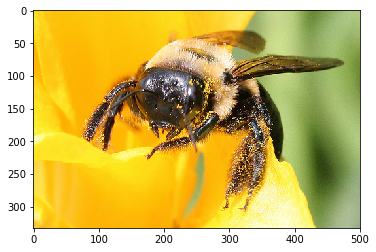

In [30]:
import os, json
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open('./data/test_img.jpg'))

画像データに対して学習時と同じ前処理を適応し、推論が実行できる状態に変更します。  

In [31]:
import torch
from torchvision import transforms
    
def preprocess(image_file):
    """Preprocess the input image."""
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_file)
    image = data_transforms(image).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image.numpy()

デプロイしたAPIを使用して推論を実行します。  

In [32]:
input_data = preprocess('./data/test_img.jpg')
result = service.run(input_data=json.dumps({'data': input_data.tolist()}))
print(result)

{'label': 'bees', 'probability': '0.99607533'}


うまく推論ができていることが確認できました。  
このデプロイされたモデルに関してはAzure Portalの「デプロイ」タブから詳細情報について確認することができます。  

これでAzure Machine Learningの基礎的な使用方法が理解できました。  

## 後片付け

Webサービスが不要になったら、API呼び出しで簡単に削除できます。

In [33]:
service.delete()

続いては一緒に手持ちのデータを使用して学習を行う方法を確認します。  
また今回は行わなかったハイパーパラメータの調整方法もご紹介します。  